In [179]:
include("./main_parser.jl")

draw_hg (generic function with 1 method)

In [12]:
using PyCall, BSON, DecisionTree, Random, CSV

In [13]:
BSON.@load "models/model_rf.bson" rf uniques

spacy = pyimport("spacy")

nlp = spacy.load("en_core_web_lg")

PyObject <spacy.lang.en.English object at 0x7f354dc35cd0>

In [21]:
data = DataFrame(CSV.File("data/articles_modified_short.csv"));

In [22]:
df = convert_df(data[:, 1], uniques, rf);

In [23]:
data = innerjoin(df, data, on =:Article);

In [24]:
nrow(data)

511

In [25]:
nrow(filter(:relation => ==(0), data))

232

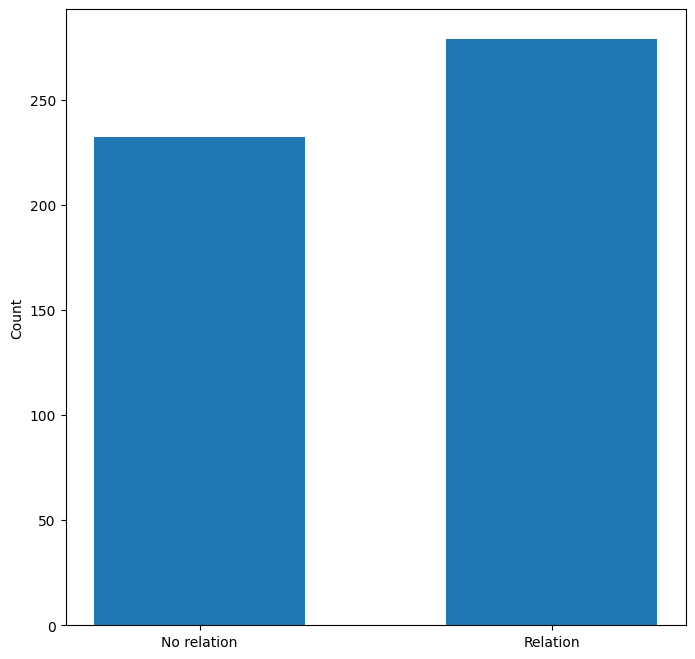

In [26]:
using PyPlot
fig, ax = subplots(figsize=(8,8))
PyPlot.bar([0, 1], [nrow(filter(:relation => ==(0), data)), 
                        nrow(filter(:relation => ==(1), data))],
            width=0.6)
PyPlot.xticks([0,1 ], ["No relation", "Relation"])
PyPlot.ylabel("Count")
PyPlot.savefig("hist.png");

In [27]:
atoms = data[:, :Atoms];

In [28]:
atoms_dict = Dict()
for article in atoms
    for atom in article
        if !(atom in keys(atoms_dict))
            atoms_dict[atom] = 1
        else
            atoms_dict[atom] += 1
        end
    end
end

In [29]:
atoms_dict

Dict{Any, Any} with 6 entries:
  "B" => 200
  "J" => 29
  "M" => 588
  "C" => 2342
  "P" => 533
  "T" => 494

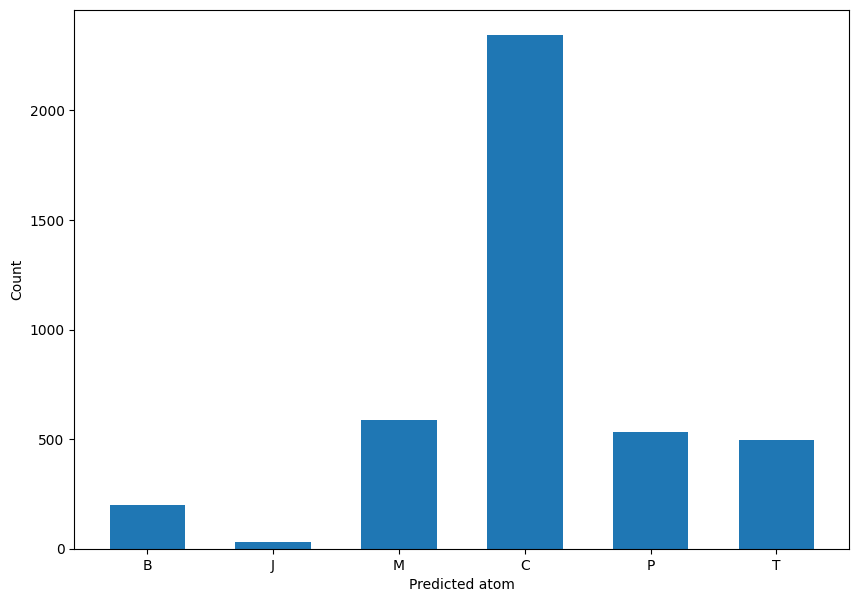

In [31]:
fig, ax = subplots(figsize=(10,7))
PyPlot.bar([1,2,3,4,5,6], [value for value in values(atoms_dict)],
            width=0.6)
PyPlot.ylabel("Count")
PyPlot.xticks([1,2,3,4,5,6], [key for key in keys(atoms_dict)])
PyPlot.xlabel("Predicted atom")
PyPlot.savefig("atoms.png");

In [389]:
predicates = ["dips", "rebounds", "firms"]
currencies = ["pound", "dollar", "sterling", "euro", "dollar", "lira", "aussie",
              "gbpusd", "gbp", "usdcad", "sterlin", "myanmar", "yuan", "zloty", "forint",
              "yen", "usd/cad", "ruble", "lebanon's", "rouble", "swiss", "rupee",
              "eur/usd"];

In [390]:
function get_hg_tokens(text, atoms, currencies=[], predicates=[])
    doc = nlp(text)
#     hg, tokens = nothing
    try
        for (i, token) in enumerate(doc)
            if lowercase(token.text) in currencies
                atoms[i] = "C"
            end
            if lowercase(token.text) in predicates
                atoms[i] = "P"
            end
        end
        beta(patterns, doc, atoms)
    catch e
        return nothing
    end
#     return hg, tokens
end

get_hg_tokens (generic function with 4 methods)

In [391]:
function model_1(currencies_list, article)
    if any(y -> occursin(y, lowercase(article)), currencies_list)
        return 1
    else
        return 0
    end
end     

model_1 (generic function with 1 method)

In [392]:
function model_2(currencies_list, article)
    output = 0
    currencies_indexes = []
    doc = nlp(article)
    for (i, token) in enumerate(doc)
        if lowercase(token.text) in currencies_list
            append!(currencies_indexes, i)
        end
    end
    for i in currencies_indexes
        if length(doc) > i
            if doc[i+1].pos_ == "VERB"
                output = 1
            end
        end
    end
    return output
end   

model_2 (generic function with 1 method)

In [393]:
function check_curr(token, currencies_list)
    curr_check = lowercase(token.text) in currencies_list
    return curr_check
end 

check_curr (generic function with 1 method)

In [394]:
x = ["to"]
any(x -> lowercase(x) in ["to", "for"], x)

true

In [395]:
function check_connector(input)
    last_tokens = input[1]
    t_index = findall(x->x == "T", last_tokens)
    if length(t_index) == 0
        return true
    else
        t_texts = []
        for token in input[2][t_index]
            try
                append!(t_texts, [token.text])
            catch e
            end
        end
        if any(y-> lowercase(y) in ["to", "for"], t_texts)
            return false
        else
            return true
        end
    end
end

check_connector (generic function with 1 method)

In [396]:
function model_3(article, atoms, currencies_list, predicates)
    output = 0
    doc = nlp(article)
    out = get_hg_tokens(article, atoms, currencies_list, predicates)
#     if (!(out == nothing) & (any(y -> occursin(y, lowercase(article)), currencies_list)))
    if !(out == nothing)
        indexes = findall(x -> x in ['S', 'R'], out[3])
        for index in indexes
            relations = findall(x -> x==1, out[1][:, index])
            if length(relations) > 3
                for word in relations
                    curr = check_curr(doc[word], currencies_list)
                    if curr
#                         conn = check_connector(out[2][index-1])
#                         if conn
#                             return 1
#                         else
#                             return 0
#                         end
                        return 1
                    end
                end
            end
        end
    end
    return 0
end

model_3 (generic function with 1 method)

In [397]:
insertcols!(data, 4, :Model1 => 0, :Model2 => 0, :Model3 => 0);

LoadError: ArgumentError: Column Model1 is already present in the data frame which is not allowed when `makeunique=true`

In [398]:
for row in eachrow(data)
    row.Model1 = model_1(currencies, row.Article)
    row.Model2 = model_2(currencies, row.Article)
    row.Model3 = model_3(row.Article, row.Atoms, currencies, predicates)
end

In [399]:
function recall(target, model)
    p1 = filter(row -> (row[model] == 1) & (row[target] == 1), data)
    p2 = filter(row -> row[target] == 1, data)
    return nrow(p1)/nrow(p2)
end

recall (generic function with 1 method)

In [400]:
function precision(target, model)
    p1 = filter(row -> (row[model] == 1) & (row[target] == 1), data)
    p2 = filter(row -> (row[model] == 1) & (row[target] == 0), data)
    return nrow(p1)/(nrow(p2) + nrow(p1))
end

precision (generic function with 1 method)

In [401]:
function f1(precision, recall)
    return 2*precision*recall/(precision+recall)
end

f1 (generic function with 1 method)

In [402]:
prec = precision("relation", "Model1")

0.7965116279069767

In [403]:
rec = recall("relation", "Model1")

0.982078853046595

In [404]:
f1(prec, rec)

0.8796147672552166

In [405]:
prec = precision("relation", "Model2")

0.7941176470588235

In [406]:
rec = recall("relation", "Model2")

0.3870967741935484

In [407]:
f1(prec, rec)

0.5204819277108433

In [408]:
prec = precision("relation", "Model3")

0.8561872909698997

In [409]:
rec = recall("relation", "Model3")

0.9175627240143369

In [410]:
f1(prec, rec)

0.8858131487889273

In [411]:
false_negative = filter(row -> (row["Model3"] == 1) & (row["relation"] == 0), data)

,Article
,String
1,GBPUSD working on its 3rd day higher but the going is relatively slow
2,Lending data from China is due soon - record new yuan loans expected
3,USDCAD tries to keep the upside momentum going
4,Republican senator urges US to monitor China's digital yuan push during Olympics
5,HSBC Strategist Sees Bullish Pound Risks Going Into BOE Meeting
6,Dollar on track for best year since 2015
7,Pound’s Pandemic Peak Versus Euro Shows Faith in Rate Divergence
8,Former FX official says China should avoid excess yuan appreciation
9,Turkish Lira Extends Selloff Past 14 Per Dollar to Record Low


In [332]:
hg, edges, atoms = get_hg_tokens(false_negative[18, 1], false_negative[18, 2], currencies, predicates);

In [333]:
atoms

4-element Vector{Any}:
 "C"
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'S': ASCII/Unicode U+0053 (category Lu: Letter, uppercase)
 'S': ASCII/Unicode U+0053 (category Lu: Letter, uppercase)

In [334]:
edges

Dict{Int64, Tuple{Vector{String}, Vector{PyObject}}} with 5 entries:
  0 => (["C", "C", "T", "M", "C"], [PyObject Lira, PyObject Slumps, PyObject to…
  4 => (["S"], [PyObject [[[Lira, Slumps], to], [New, Low]]])
  2 => (["C", "T", "C"], [PyObject [Lira, Slumps], PyObject to, PyObject [New, …
  3 => (["S", "C"], [PyObject [[Lira, Slumps], to], PyObject [New, Low]])
  1 => (["C", "T", "M", "C"], [PyObject [Lira, Slumps], PyObject to, PyObject N…

In [335]:
edges[4]

(["S"], PyObject[PyObject [[[Lira, Slumps], to], [New, Low]]])

In [339]:
check_connector(edges[2])

[2]PyObject to
false

false